# "Concevez une application au service de la santé publique"
_Cleaning Notebook_
13/08 16h

## 0. Preliminaries

### 0.0 Importing Modules

In [0]:
import sys
# Checking whether the notebook is on Colab or PC
is_colab = 'google.colab' in sys.modules
is_colab, sys.executable

(True, '/usr/bin/python3')

In [0]:
# Installations and importations required for Google Colab version
if is_colab==True:
  from google.colab import files, output
  !pip install python-stdnum
  !pip install gTTS
  !pip install ipywidgets
else:
    pass

     |████████████████████████████████| 849kB 6.2MB/s 
  Created wheel for gtts-token: filename=gTTS_token-1.1.3-cp36-none-any.whl size=4097 sha256=229d3f618abd68b70fb5431fac1de9257915a0bf935e5bb30898574055f34b33
  Stored in directory: /root/.cache/pip/wheels/dd/11/61/33f7e51bf545e910552b2255eead2a7cd8ef54064b46dceb34
Successfully built gtts-token


In [0]:
## IMPORTATIONS

import os
import io

# to display small dataframes side by side
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),
                 raw=True)

import pandas as pd
dict_pd_settings = {'display.max_rows': 500, 'display.width': 100,
                    'display.max_colwidth': 20,
                    'display.float_format': lambda x: '%.0f' % x}
for k,v in dict_pd_settings.items():
  pd.set_option(k,v)

import pandas_profiling
import missingno as msno

from stdnum.exceptions import *
from stdnum.util import *
# from stdnum.util import clean, isdigits
from stdnum.ean import *

import string
from random import randint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import ipywidgets as widg
from ipywidgets import interact, interact_manual

import scipy.stats as st

import re
import time

# %pprint # turns off pretty printing

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# To play audio text-to-speech during execution
from IPython.display import Audio
from gtts import gTTS

def speak(my_text):
    with io.BytesIO() as f:
        gTTS(text=my_text, lang='en').write_to_fp(f)
        f.seek(0)
        return Audio(f.read(), autoplay=True)

In [0]:
speak('Packages and modules successfully imported')

### 0.1 Importing dataset

In [0]:
if is_colab==False:
  # Importing database from my current local Git Repo
  df = pd.read_csv('../DATA/en.openfoodfacts.org.products.csv',\
                     sep='\t', low_memory=False, encoding ='utf-8')#, nrows=1000)
  print("Imported from PC")
else:
  # Importing database from the Internet
  if not os.path.exists('en.openfoodfacts.org.products.csv'):
    !wget https://static.openfoodfacts.org/data/en.openfoodfacts.org.products.csv
  else:
    pass
  df = pd.read_csv('en.openfoodfacts.org.products.csv',
                   sep='\t', low_memory=False, encoding ='utf-8')
  print("Imported from colab environment")

--2020-04-21 08:42:11--  https://static.openfoodfacts.org/data/en.openfoodfacts.org.products.csv
Resolving static.openfoodfacts.org (static.openfoodfacts.org)... 213.36.253.206
Connecting to static.openfoodfacts.org (static.openfoodfacts.org)|213.36.253.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2513375517 (2.3G) [text/csv]
Saving to: ‘en.openfoodfacts.org.products.csv’

en.openfoodfacts.or 100%[===================>]   2.34G  49.6MB/s    in 31s     

2020-04-21 08:42:43 (77.0 MB/s) - ‘en.openfoodfacts.org.products.csv’ saved [2513375517/2513375517]

Imported from colab environment


In [0]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1215651 entries, 0 to 1215650
Columns: 181 entries, code to carnitine_100g
dtypes: float64(123), int64(2), object(56)
memory usage: 6.0 GB


In [0]:
df.head(3)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,allergens_en,traces,traces_tags,traces_en,...,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0000000000017,http://world-en....,kiliweb,1529059080,2018-06-15T10:38...,1561463718,2019-06-25T11:55...,Vitória crackers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,France,en:france,France,NaN,NaN,nan,NaN,NaN,NaN,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,0000000000031,http://world-en....,isagoofy,1539464774,2018-10-13T21:06...,1539464817,2018-10-13T21:06...,Cacao,NaN,130 g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,France,en:france,France,NaN,NaN,nan,NaN,NaN,NaN,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,000000000003327986,http://world-en....,kiliweb,1574175736,2019-11-19T15:02...,1574175737,2019-11-19T15:02...,Filetes de pollo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,en:es,en:spain,Spain,NaN,NaN,nan,NaN,NaN,NaN,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [0]:
speak('Dataset successfully imported')

### 0.2 First Overview

In [0]:
# Shape of the dataset
dfshape = df.shape # (1173417, 178) (954463, 175)
dfshape

(1215651, 181)

In [0]:
# General description 
desc_df = df.describe(include='all')
# Types and content of the columns
desc_type = pd.DataFrame(df.dtypes, columns=['type']).T
nb_null = (dfshape[0]-desc_df.loc["count"].T)
pct_null = (dfshape[0]-desc_df.loc["count"].T)*100/dfshape[0]
desc_null = pd.DataFrame([nb_null, pct_null], index=['nb null','pct null'])
# Concatenate general, type and null stats
my_desc = pd.concat([desc_type, desc_null, desc_df])
my_desc

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,allergens_en,traces,traces_tags,traces_en,...,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
type,object,object,object,int64,object,int64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,float64,object,object,object,object,object,object,object,object,float64,object,object,object,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
nb null,0,0,4,0,0,0,0,60108,1117196,836136,1003625,1003634,456694,456743,767706,767709,767709,1156723,1156822,1121819,1121856,915510,915489,915489,1140697,1140725,1167998,1215651,1164447,1083485,1019269,2123,2125,2125,736015,1121668,1215651,1143046,1121936,1121936,...,1212557,1209039,1215003,1212459,1215547,1215324,1189021,1215058,1068420,1208760,1072323,1207584,1210969,1213323,1213743,1215379,1214286,1215581,1215577,1214981,1215360,1215529,1215501,1209639,1215363,1204587,1215360,1210506,1215649,1215238,1205608,874173,1215607,1215648,1215651,1215614,1215644,1215629,1215612,1215634
pct null,0,0,0,0,0,0,0,5,92,69,83,83,38,38,63,63,63,95,95,92,92,75,75,75,94,94,96,100,96,89,84,0,0,0,61,92,100,94,92,92,...,100,99,100,100,100,100,98,100,88,99,88,99,100,100,100,100,100,100,100,100,100,100,100,100,100,99,100,100,100,100,99,72,100,100,100,100,100,100,100,100
count,1215651,1215651,1215647,1215651,1215651,1215651,1215651,1155543,98455,379515,212026,212017,758957,758908,447945,447942,447942,58928,58829,93832,93795,300141,300162,300162,74954,74926,47653,0,51204,132166,196382,1213528,1213526,1213526,479636,93983,0,72605,93715,93715,...,3094,6612,648,3192,104,327,26630,593,147231,6891,143328,8067,4682,2328,1908,272,1365,70,74,670,291,122,150,6012,288,11064,291,5145,2,413,10043,341478,44,3,0,37,7,22,39,17
unique,1215415,1215489,10839,NaN,1069997,NaN,946271,780130,72933,30928,36989,29951,131637,104283,85717,51744,51744,10184,8993,21294,19272,57076,42672,42672,21917,19347,2951,NaN,5046,9737,11629,7676,2830,2830,422726,5622,NaN,8794,8881,8881,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,8718452146833,http://world-en....,kiliweb,NaN,2019-03-11T15:48...,NaN,2019-03-16T21:14...,Aceite de oliva ...,Pâtes alimentair...,500 g,"sachet,plastique","sachet,plastique",Carrefour,carrefour,Boissons,en:beverages,Beverages,France,france,France,france,en:gluten-free,en:gluten-free,Gluten-free,FR 72.264.002 EC,fr-72-264-002-ec,"47.833333,-0.333333",NaN,sable-sur-sarthe...,France,Carrefour,France,en:france,France,Contient des sul...,en:milk,NaN,en:nuts,en:nut

In [0]:
print(tuple(df.columns.values))

('code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'product_name', 'generic_name', 'quantity', 'packaging', 'packaging_tags', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_en', 'origins', 'origins_tags', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_en', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places', 'stores', 'countries', 'countries_tags', 'countries_en', 'ingredients_text', 'allergens', 'allergens_en', 'traces', 'traces_tags', 'traces_en', 'serving_size', 'serving_quantity', 'no_nutriments', 'additives_n', 'additives', 'additives_tags', 'additives_en', 'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags', 'nutriscore_score', 'nutriscore_grade', '

14 columns with no entry, no row has all the columns filled.

In [0]:
speak('Description overview done')

### 0.3 Memory usage reduction

In order to facilitate the manipulation, we change the format of encoding
- ints and floats are to be downcasted
- objects are to be changed to category (if the number of unique values is less tha, half the number of rows)

NB: If we already know the format of data, we can specify the format of each column while loading the data in a pandas dataframe: *pd.read_csv('path', dtype=my_dict)*

In [0]:
# # Checking memory usage
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1215651 entries, 0 to 1215650
Columns: 181 entries, code to carnitine_100g
dtypes: float64(123), int64(2), object(56)
memory usage: 6.0 GB


In [0]:
def mem_usage(pandas_obj):
  if isinstance(pandas_obj,pd.DataFrame):
    usage_b = pandas_obj.memory_usage(deep=True).sum()
  else:
    usage_b = pandas_obj.memory_usage(deep=True)    
  usage_mb = usage_b / 1024 ** 2
  return "{:03.2f} MB".format(usage_mb)

In [0]:
# columns 'category'
df_obj = df.select_dtypes(include=['object']).copy()
converted_obj = pd.DataFrame()
for col in df_obj.columns:
  if len(df_obj[col].unique()) / len(df_obj[col]) < 0.5:
    converted_obj.loc[:,col] = df_obj[col].astype('category')
  else:
    converted_obj.loc[:,col] = df_obj[col]
print('For {} object columns: {} before, {} after conversion to category.'\
      .format(df_obj.shape[1], mem_usage(df_obj), mem_usage(converted_obj)))

For 56 object columns: 4957.28 MB before, 1642.21 MB after conversion to category.


In [0]:
# columns 'int'
df_int = df.select_dtypes(include=['int']).copy()
converted_int = df_int.apply(pd.to_numeric, downcast='unsigned')
print('For {} int columns: {} before, {} after downcasting.'\
      .format(df_int.shape[1], mem_usage(df_int), mem_usage(converted_int)))

For 2 int columns: 18.55 MB before, 9.27 MB after downcasting.


In [0]:
# columns 'float'
df_float = df.select_dtypes(include=['float']).copy()
converted_float = df_float.apply(pd.to_numeric, downcast='float')
print('For {} float columns: {} before, {} after downcasting.'\
      .format(df_float.shape[1], mem_usage(df_float), mem_usage(converted_float)))

For 123 float columns: 1140.79 MB before, 570.39 MB after downcasting.


In [0]:
dfcopy = pd.DataFrame()
dfcopy[converted_obj.columns] = converted_obj
dfcopy[converted_int.columns] = converted_int
dfcopy[converted_float.columns] = converted_float

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1215651 entries, 0 to 1215650
Columns: 181 entries, code to carnitine_100g
dtypes: category(47), float32(123), object(9), uint32(2)
memory usage: 2.2 GB


In [0]:
dfcopy.info(memory_usage='deep')

In [0]:
del df, df_obj, converted_obj, df_int, converted_int, df_float, converted_float

In [0]:
speak("Reduction of memory usage done")

Main conclusions : 
- Description :
  954463 rows and 175 columns
  some of them categorical, 
  some of them numerical
- Memory usage reduction : 
  6.0 GB -> 2.2 GB

### 0.4 Pandas Data Profiling report

In [0]:
# Generating a Data Profiling html report via pandas_profiling
# profile = pandas_profiling.ProfileReport(dfcopy) #, check_correlation = False
# profile.to_file("OFFacts_report2_3.html")
# profile

In [0]:
# # extract rejected columns (based on correlation coeff greater than 0.9)
# rejected_variables_90 = profile.get_rejected_variables(threshold=0.9)
# len(rejected_variables_90)

In [0]:
# speak('Pandas profiling report generated')

Main conclusions : 

## 1. Dropping columns and rows

### 1. Filtering out non relevant columns
Some columns can immediately be classified as non useful for our project and therefore dropped : 
- 5 columns concerning to the image of the product: 'image_small_url',	'image_ingredients_url',	'image_ingredients_small_url',	'image_nutrition_url'	'image_nutrition_small_url'
- 3 columns concerning the level of completion of the row: 'states', 'states_tags', 'states_en' 


In [0]:
li_col_del = ['image_url', 'image_small_url',	'image_ingredients_url',
              'image_ingredients_small_url',	'image_nutrition_url',
              'image_nutrition_small_url',
              'states', 'states_tags', 'states_en' ]
# Filtering out 8 non relevant columns
dfcopy.drop(columns=li_col_del, inplace=True)
dfcopy.shape

(1215651, 172)

### 2. Almost empty columns

Let's see how the columns are filled.


In [0]:
# Checking nb of not null values in the columns
nbnotnulldf = pd.DataFrame((~dfcopy.isna()).sum(axis =0), columns=['nb'])
nbnotnulldf.sort_values(by=['nb'], axis=0, ascending=True, inplace=True)
nbnotnulldf.T.head(150)

,no_nutriments,cities,-lignoceric-acid_100g,ingredients_from_palm_oil,water-hardness_100g,-erucic-acid_100g,ingredients_that_may_be_from_palm_oil,allergens_en,brand_owner,-nervonic-acid_100g,-caproic-acid_100g,-elaidic-acid_100g,-melissic-acid_100g,-gondoic-acid_100g,-mead-acid_100g,-butyric-acid_100g,-caprylic-acid_100g,-dihomo-gamma-linolenic-acid_100g,-myristic-acid_100g,-stearic-acid_100g,-montanic-acid_100g,chlorophyl_100g,glycemic-index_100g,-cerotic-acid_100g,-palmitic-acid_100g,-capric-acid_100g,-gamma-linolenic-acid_100g,-behenic-acid_100g,phylloquinone_100g,-maltose_100g,-lauric-acid_100g,nucleotides_100g,-maltodextrins_100g,carnitine_100g,-arachidic-acid_100g,-oleic-acid_100g,beta-glucan_100g,-soluble-fiber_100g,-insoluble-fiber_100g,-arachidonic-acid_100g,...,labels_tags,fiber_100g,nutriscore_grade,nutriscore_score,nutrition-score-fr_100g,nova_group,quantity,main_category,categories_tags,main_category_en,categories_en,categories,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,ingredients_text,brands_tags,brands,energy-kcal_100g,saturated-fat_100g,sugars_100g,sodium_100g,salt_100g,carbohydrates_100g,fat_100g,proteins_100g,energy_100g,product_name,pnns_groups_1,countries_en,countries_tags,countries,pnns_groups_2,creator,created_t,last_modified_t,last_modified_datetime,created_datetime,url,code
nb,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,2,2,3,3,3,4,5,7,7,9,9,13,16,17,21,22,22,23,24,29,...,300162,315014,341469,341469,341478,347116,379515,447942,447942,447942,447942,447945,479636,479636,479636,479636,758908,758957,885488,918631,935808,936764,936805,950515,950538,951924,958351,1155543,1202575,1213526,1213526,1213528,1214904,1215647,1215651,1215651,1215651,1215651,1215651,1215651


In [0]:
# Displaying a table with bins
mask = pd.cut(nbnotnulldf['nb'], [-1,0,5,10,100,300,1000000]) # 
mask.value_counts(normalize=False, sort=False)

(-1, 0]           15
(0, 5]            12
(5, 10]            4
(10, 100]         21
(100, 300]        11
(300, 1000000]    96
Name: nb, dtype: int64

In [0]:
# Plotting nb of not null per column
@interact_manual
def plot_more_than_n_notna(n =(1,1000,50)):
   ax = nbnotnulldf['nb'][nbnotnulldf['nb']>n].reset_index()\
                .plot.bar(x='index', y='nb', figsize=(25,4))
   ax.set(yscale='log')
   return ax

interactive(children=(IntSlider(value=451, description='n', max=1000, min=1, step=50), Button(description='Run…

In [0]:
# Displaying names of columns with less than 300 entries
mask = pd.cut(nbnotnulldf['nb'], [-1,300])
li_col_del = list(mask[~mask.values.isna()].index)
len(li_col_del), li_col_del

(63,
 ['no_nutriments',
  'cities',
  '-lignoceric-acid_100g',
  'ingredients_from_palm_oil',
  'water-hardness_100g',
  '-erucic-acid_100g',
  'ingredients_that_may_be_from_palm_oil',
  'allergens_en',
  'brand_owner',
  '-nervonic-acid_100g',
  '-caproic-acid_100g',
  '-elaidic-acid_100g',
  '-melissic-acid_100g',
  '-gondoic-acid_100g',
  '-mead-acid_100g',
  '-butyric-acid_100g',
  '-caprylic-acid_100g',
  '-dihomo-gamma-linolenic-acid_100g',
  '-myristic-acid_100g',
  '-stearic-acid_100g',
  '-montanic-acid_100g',
  'chlorophyl_100g',
  'glycemic-index_100g',
  '-cerotic-acid_100g',
  '-palmitic-acid_100g',
  '-capric-acid_100g',
  '-gamma-linolenic-acid_100g',
  '-behenic-acid_100g',
  'phylloquinone_100g',
  '-maltose_100g',
  '-lauric-acid_100g',
  'nucleotides_100g',
  '-maltodextrins_100g',
  'carnitine_100g',
  '-arachidic-acid_100g',
  '-oleic-acid_100g',
  'beta-glucan_100g',
  '-soluble-fiber_100g',
  '-insoluble-fiber_100g',
  '-arachidonic-acid_100g',
  'additives',
  '

In [0]:
# Printing remaining columns
[s for s in list(dfcopy.columns) if s not in li_col_del]

['code',
 'url',
 'creator',
 'created_datetime',
 'last_modified_datetime',
 'product_name',
 'generic_name',
 'quantity',
 'packaging',
 'packaging_tags',
 'brands',
 'brands_tags',
 'categories',
 'categories_tags',
 'categories_en',
 'origins',
 'origins_tags',
 'manufacturing_places',
 'manufacturing_places_tags',
 'labels',
 'labels_tags',
 'labels_en',
 'emb_codes',
 'emb_codes_tags',
 'first_packaging_code_geo',
 'cities_tags',
 'purchase_places',
 'stores',
 'countries',
 'countries_tags',
 'countries_en',
 'ingredients_text',
 'allergens',
 'traces',
 'traces_tags',
 'traces_en',
 'serving_size',
 'additives_tags',
 'additives_en',
 'ingredients_from_palm_oil_tags',
 'ingredients_that_may_be_from_palm_oil_tags',
 'nutriscore_grade',
 'pnns_groups_1',
 'pnns_groups_2',
 'main_category',
 'main_category_en',
 'created_t',
 'last_modified_t',
 'serving_quantity',
 'additives_n',
 'ingredients_from_palm_oil_n',
 'ingredients_that_may_be_from_palm_oil_n',
 'nutriscore_score',
 'no

We keep columns with more than 300 values except:
- 'carbon-footprint_100g', 'carbon-footprint-from-meat-or-fish_100g',
'fruits-vegetables-nuts_100g', 'fruits-vegetables-nuts-estimate_100g', as they would require more data to be exploitable

We drop columns with less than 300 values except:
- 'ph_100g' as it could be useful to study a subset of mineral waters

In [0]:
# Putting back pH as it could be useful to study mineral waters for example
li_col_del.remove('ph_100g')
# Adding 4 columns from the "to-be-deleted" columns list 
li_col_del += ['carbon-footprint_100g',
               'carbon-footprint-from-meat-or-fish_100g',
               'fruits-vegetables-nuts_100g',
               'fruits-vegetables-nuts-estimate_100g']
print(f'nb of columns to drop: {len(li_col_del)}')

nb of columns to drop: 66


In [0]:
print("shape before", dfcopy.shape)
dfcopy.drop(columns=li_col_del, inplace=True)
print("shape after", dfcopy.shape)

shape before (1215651, 172)
shape after (1215651, 106)


We rearrange the columns with similar contents at the same place:

In [0]:
# Function that moves similar categories at the same place
def move_cat_containing(my_index, strings):
  idx_sel = []
  for s in strings:
    idx_sel += [i for i,x in enumerate(my_index)\
             if x in my_index[my_index.str.contains(s)]]
  to_move = my_index[idx_sel]
  rank = max(idx_sel)
  mod_index = my_index.drop(to_move)
  for c in to_move:
    mod_index = mod_index.insert(rank,c)
  return mod_index

In [0]:
# Moving 'nutriscores' and 'categories'
cols = dfcopy.columns
cols = move_cat_containing(cols,['categ','pnns'])
cols = move_cat_containing(cols,['nutri', 'nova'])
list(cols)

['code',
 'url',
 'creator',
 'created_datetime',
 'last_modified_datetime',
 'product_name',
 'generic_name',
 'quantity',
 'packaging',
 'packaging_tags',
 'brands',
 'brands_tags',
 'origins',
 'origins_tags',
 'manufacturing_places',
 'manufacturing_places_tags',
 'labels',
 'labels_tags',
 'labels_en',
 'emb_codes',
 'emb_codes_tags',
 'first_packaging_code_geo',
 'cities_tags',
 'purchase_places',
 'stores',
 'countries',
 'countries_tags',
 'countries_en',
 'ingredients_text',
 'allergens',
 'traces',
 'traces_tags',
 'traces_en',
 'serving_size',
 'additives_tags',
 'additives_en',
 'ingredients_from_palm_oil_tags',
 'ingredients_that_may_be_from_palm_oil_tags',
 'created_t',
 'last_modified_t',
 'serving_quantity',
 'additives_n',
 'ingredients_from_palm_oil_n',
 'ingredients_that_may_be_from_palm_oil_n',
 'pnns_groups_2',
 'pnns_groups_1',
 'main_category_en',
 'main_category',
 'categories_en',
 'categories_tags',
 'categories',
 'energy-kj_100g',
 'energy-kcal_100g',
 'ener

In [0]:
dfcopy = dfcopy.reindex(columns=cols)
dfcopy.head(1)

,code,url,creator,created_datetime,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,traces,traces_tags,traces_en,serving_size,additives_tags,additives_en,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_tags,created_t,last_modified_t,...,-lactose_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,selenium_100g,iodine_100g,ph_100g,cocoa_100g,nutriscore_grade,nutriscore_score,nutrition-score-fr_100g,nova_group
0,0000000000017,http://world-en....,kiliweb,2018-06-15T10:38...,2019-06-25T11:55...,Vitória crackers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1529059080,1561463718,...,nan,nan,nan,nan,8,1,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,nan,nan,nan


### 3. Columns with redundant information

Some of the columns seem to contain similar information. For example : 
  - 'created_t' vs.	'created_datetime'
  - 'last_modified_t' vs.	'last_modified_datetime'
  - 'brands' vs.	'brands_tags'
  - 'categories	' vs.	'categories_tags'  vs.	'categories_en'  
  - 'origins' vs.	'origins_tags'
  - 'manufacturing_places' vs.	'manufacturing_places_tags'
  - 'labels' vs.	'labels_tags'  vs.	'labels_en' 
  - 'emb_codes' vs.	'emb_codes_tags'
  - 'countries' vs.	'countries_tags'  vs.	'countries_en'
  - 'traces' vs.	'traces_tags'  vs.	'traces_en'
  - 'additives_n' vs. 'additives' vs.	'additives_tags'  vs.	'additives_en'


Let's see if some of them can be dropped or their content gathered in only one column.
To that end, we define a function '**comp_df**' that :
- compares the content of two columns col1 and col2 of the dataframe
- prints the number or rows with 1) both columns, 2) col1 only, 3) col2 only, and 4) none of them filled
- returns indexes of 1) data in both columns, 2) data only in col1, 3) data only in col2, and 4) no data at all.

After that, we check and compare the content of the columns when both are filled in order to get familiar with the content of the database and determine the columns that can be dropped.

In [0]:
def comp_df (df, col1, col2, print_Y_N):
  mboth = (~df[[col1,col2]].isna()).sum(axis=1)==2 # mask for both cells filled
  mone = (~df[[col1,col2]].isna()).sum(axis=1)==1 # mask for only one cell filled
  mcol1 = mone & ~df[col1].isna() # mask for only col1 cell filled
  mcol2 = mone & ~df[col2].isna() # mask for only col2 cell filled
  mnone = ~mone & ~mboth
  ind_both = df.index[mboth].to_list()
  ind_col1 = df.index[mcol1].to_list()
  ind_col2 = df.index[mcol2].to_list()
  ind_none = df.index[mnone].to_list()
  if print_Y_N :
    print("nb rows both filled: ", len(ind_both))
    print("nb rows with only", col1, "filled: ", len(ind_col1))
    print("nb rows with only", col2, "filled: ", len(ind_col2))
    print("nb rows not filled: ", len(ind_none))
  else:
    pass
  return(ind_both, ind_col1, ind_col2, ind_none)

In [0]:
# Printing amount of rows in each case:
#(col1 filled, col2 filled, both filled, none filled)
li_col = ['packaging', 'brands', 'categories', 'origins', 'manufacturing_places',
        'labels', 'emb_codes','countries', 'traces']
for c in li_col:
  c1 = c
  c2 = c+'_tags'
  print('COLUMN', c,':')
  t_ind = comp_df(dfcopy, c1, c2, True)
  dfcopy.loc[t_ind[1], [c1,c2]] = np.nan

COLUMN packaging :
nb rows both filled:  212015
nb rows with only packaging filled:  11
nb rows with only packaging_tags filled:  2
nb rows not filled:  1003623
COLUMN brands :
nb rows both filled:  758900
nb rows with only brands filled:  57
nb rows with only brands_tags filled:  8
nb rows not filled:  456686
COLUMN categories :
nb rows both filled:  447942
nb rows with only categories filled:  3
nb rows with only categories_tags filled:  0
nb rows not filled:  767706
COLUMN origins :
nb rows both filled:  58826
nb rows with only origins filled:  102
nb rows with only origins_tags filled:  3
nb rows not filled:  1156720
COLUMN manufacturing_places :
nb rows both filled:  93795
nb rows with only manufacturing_places filled:  37
nb rows with only manufacturing_places_tags filled:  0
nb rows not filled:  1121819
COLUMN labels :
nb rows both filled:  300123
nb rows with only labels filled:  18
nb rows with only labels_tags filled:  39
nb rows not filled:  915471
COLUMN emb_codes :
nb rows

We design an interactive feature that helps to browse between



Here is an example of the code we have used to address 'brands' and 'brands_tags' columns:

In [0]:
@interact
def print_comp_info(col=li_col):
  c1 = col
  c2 = c1+'_tags'
  # Comparing content of 2 columns, print info and returns indexes 
  t_ind = comp_df(dfcopy, c1, c2, True)
  # Displaying a random sample of cells:
  '''- when col1 only is filled
  - when col2 only is filled
  - when both columns are filled'''
  display_side_by_side(dfcopy.loc[t_ind[1],[c1, c2]]\
                       .sample(5 if len(t_ind[1])>5 else len(t_ind[1])),
                      dfcopy.loc[t_ind[2], [c1, c2]]\
                       .sample(5 if len(t_ind[2])>5 else len(t_ind[2])),
                      dfcopy.loc[t_ind[0], [c1, c2]]\
                       .sample(5 if len(t_ind[0])>5 else len(t_ind[0])))

interactive(children=(Dropdown(description='col', options=('packaging', 'brands', 'categories', 'origins', 'ma…

After examination of all the columns above-listed, we decide :
- to set values of the 'XXX' column to NaN if not matching with a non NaN value in the 'XXX_tags' column (as we found that they correspond to erroneous values ('?', '/', '-', etc.));
- to drop 'created_t' and 'last_modified_t';
- to drop 'packaging_tags', 'brands_tags', 'categories_tags', 'origins_tags', 'manufacturing_places_tags', 'labels_tags', 'emb_codes_tags', 'countries_tags', 'traces_tags', 'additives_tags', as the data they contain are redundant with 'XXX' or 'XXX_en' columns; 
- to drop 'additives' column, as it does not contain enough data (29 entries), that are however in english in 'additives_en'
- to keep 'XXX_en' columns, as they contain useful and sometimes original data;
- to keep 'XXX' columns.

In [0]:
# Setting values of the 'XXX' column to NaN if no value in 'XXX_tag' 
t_ind = comp_df(dfcopy, c1, c2, False)
dfcopy.loc[t_ind[1], [c1,c2]] = np.nan

In [0]:
# Dropping unuseful columns
li_col_del = ['created_t', 'last_modified_t','packaging_tags',
             'brands_tags', 'categories_tags', 'origins_tags', 
             'manufacturing_places_tags', 'labels_tags',
             'emb_codes_tags','countries_tags', 'traces_tags',
             'additives_tags']

print("shape before", dfcopy.shape)
dfcopy.drop(columns=li_col_del, inplace=True)
print("shape after", dfcopy.shape)

shape before (1215651, 106)
shape after (1215651, 94)


In [0]:
# Checking the remaining columns
list(dfcopy.columns)

['code',
 'url',
 'creator',
 'created_datetime',
 'last_modified_datetime',
 'product_name',
 'generic_name',
 'quantity',
 'packaging',
 'brands',
 'origins',
 'manufacturing_places',
 'labels',
 'labels_en',
 'emb_codes',
 'first_packaging_code_geo',
 'cities_tags',
 'purchase_places',
 'stores',
 'countries',
 'countries_en',
 'ingredients_text',
 'allergens',
 'traces',
 'traces_en',
 'serving_size',
 'additives_en',
 'ingredients_from_palm_oil_tags',
 'ingredients_that_may_be_from_palm_oil_tags',
 'serving_quantity',
 'additives_n',
 'ingredients_from_palm_oil_n',
 'ingredients_that_may_be_from_palm_oil_n',
 'pnns_groups_2',
 'pnns_groups_1',
 'main_category_en',
 'main_category',
 'categories_en',
 'categories',
 'energy-kj_100g',
 'energy-kcal_100g',
 'energy_100g',
 'energy-from-fat_100g',
 'fat_100g',
 'saturated-fat_100g',
 'monounsaturated-fat_100g',
 'polyunsaturated-fat_100g',
 'omega-3-fat_100g',
 '-alpha-linolenic-acid_100g',
 'omega-6-fat_100g',
 'trans-fat_100g',
 'ch

In [0]:
# Changing the name of some of the columns
dfcopy.rename(columns={'nutriscore_score': 'nutriscore',
                       'nutriscore_grade': 'nutrigrade',
                       'pnns_groups_1': 'pnns_gp_1',
                       'pnns_groups_2': 'pnns_gp_2',
                       'nutrition-score-fr_100g':'nutriscore-fr'},
              inplace=True)

Some columns are related and provide information useful to retrieve data via feature engineering.
To help automatizing these tasks, we categorize the columns as follows :

**li_cat_fat**: 'saturated_fat_100g', 'monounsaturated_fat_100g', 'polyunsaturated_fat_100g', 'trans-fat_100g', 'cholesterol_100g'

**li_cat_poly_fat**: 'omega-3-fat_100g', 'omega-6-fat_100g'

**li_cat_carb**: 'sugars_100g', 'starch_100g', 'polyols_100g', 'fibers_100g', '-lactose_100g'

**li_cat_comp**: cat_fat, cat_carb, 'proteins_100g'

**li_cat_vit-oligo**:  'vitamin-a_100g',	'vitamin-d_100g',	'vitamin-e_100g',	'vitamin-k_100g',	'vitamin-c_100g',	'vitamin-b1_100g',	'vitamin-b2_100g',	'vitamin-pp_100g',	'vitamin-b6_100g',	'vitamin-b9_100g',	'folates_100g',	'vitamin-b12_100g',	'biotin_100g',	'pantothenic-acid_100g','silica_100g', 'bicarbonate_100g',	'potassium_100g',	'chloride_100g',	'calcium_100g',	'phosphorus_100g',	'iron_100g',	'magnesium_100g',	'zinc_100g',	'copper_100g',	'manganese_100g',	'fluoride_100g', 'selenium_100g, 'chromium_100g', 'molybdenum_100g', 'iodine_100g',	'caffeine_100g', 'taurine_100g', 'cocoa_100g'

In [0]:
# Making list of columns with similar or complementary content
li_cat_carb = ['sugars_100g', 'starch_100g', 'polyols_100g',
            'fiber_100g', '-lactose_100g']
li_cat_fat = ['saturated-fat_100g', 'monounsaturated-fat_100g',
              'polyunsaturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g']
li_cat_poly_fat = ['omega-3-fat_100g', 'omega-6-fat_100g']
li_cat_comp = ['fat_100g','carbohydrates_100g', 'proteins_100g']
li_cat_vit_oligo = ['vitamin-e_100g', 'vitamin-k_100g',
                    'vitamin-c_100g', 'vitamin-b1_100g', 'vitamin-b2_100g',
                    'vitamin-pp_100g','vitamin-b6_100g', 'vitamin-b9_100g',
                    'folates_100g', 'vitamin-b12_100g', 'biotin_100g',
                    'pantothenic-acid_100g', 'bicarbonate_100g',
                    'potassium_100g', 'chloride_100g', 'calcium_100g',
                    'phosphorus_100g', 'iron_100g', 'magnesium_100g',
                    'zinc_100g', 'copper_100g', 'manganese_100g',
                    'selenium_100g', 'iodine_100g', 'cocoa_100g']
li_cat_nutri = ['nutrigrade', 'nova_group','nutriscore', 'nutriscore-fr']
li_cat_keys = ['code', 'url', 'creator',
               'created_datetime', 'last_modified_datetime', 
               'product_name', 'generic_name', 'quantity', 'packaging',
               'brands','serving_size', 'serving_quantity']
li_cat_cat = ['categories', 'categories_en', 'labels', 'labels_en',
              'pnns_gp_1', 'pnns_gp_2', 'main_category',
              'main_category_en']
li_cat_geo = ['origins', 'manufacturing_places', 'emb_codes',
              'first_packaging_code_geo', 'cities_tags', 'purchase_places',
              'stores', 'countries', 'countries_en']
li_ca_content = ['ingredients_text', 'allergens', 'traces', 'traces_en',
                 'additives_n', 'additives_en', 'ingredients_from_palm_oil_n',
                 'ingredients_from_palm_oil_tags',
                 'ingredients_that_may_be_from_palm_oil_n',
                 'ingredients_that_may_be_from_palm_oil_tags']

In [0]:
# Checking if the columns are contained in the dfcopy.columns list
for li in [li_cat_carb, li_cat_fat, li_cat_poly_fat, li_cat_comp,
           li_cat_vit_oligo, li_cat_nutri, li_cat_keys, li_cat_cat,
           li_cat_geo, li_ca_content]:
  _ = np.array([True if c in dfcopy.columns else False for c in li])
  print("----------\n", li, ":\n", np.sum(_), '/' , len(_), '|', _)

----------
 ['sugars_100g', 'starch_100g', 'polyols_100g', 'fiber_100g', '-lactose_100g'] :
 5 / 5 | [ True  True  True  True  True]
----------
 ['saturated-fat_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g'] :
 5 / 5 | [ True  True  True  True  True]
----------
 ['omega-3-fat_100g', 'omega-6-fat_100g'] :
 2 / 2 | [ True  True]
----------
 ['fat_100g', 'carbohydrates_100g', 'proteins_100g'] :
 3 / 3 | [ True  True  True]
----------
 ['vitamin-e_100g', 'vitamin-k_100g', 'vitamin-c_100g', 'vitamin-b1_100g', 'vitamin-b2_100g', 'vitamin-pp_100g', 'vitamin-b6_100g', 'vitamin-b9_100g', 'folates_100g', 'vitamin-b12_100g', 'biotin_100g', 'pantothenic-acid_100g', 'bicarbonate_100g', 'potassium_100g', 'chloride_100g', 'calcium_100g', 'phosphorus_100g', 'iron_100g', 'magnesium_100g', 'zinc_100g', 'copper_100g', 'manganese_100g', 'selenium_100g', 'iodine_100g', 'cocoa_100g'] :
 25 / 25 | [ True  True  True  True  True  True  True  True  True  Tr

In [0]:
# Interactive graph to check the number of missing values in available groups
@interact_manual
def show_msno_matrix(col_groups=[li_cat_carb, li_cat_fat, li_cat_poly_fat,
                                 li_cat_comp, li_cat_vit_oligo, li_cat_nutri,
                                 li_cat_keys, li_cat_cat,li_cat_geo,
                                 li_ca_content],
                     color=['b','r', 'g', 'y', 'k', 'p', 'c', 'm' ],
                     plt_type=['msno matrix', 'msno bars', 'msno heatmap']):
  idx_subset = pd.Index(col_groups)
  if plt_type=='msno matrix':
    return msno.matrix(dfcopy.loc[:,idx_subset],figsize=(20,5),
                     color=colors.to_rgb(color))
  elif plt_type=='msno bars':
    return msno.bar(dfcopy.loc[:,idx_subset],figsize=(20,5),
                     color=colors.to_rgb(color))
  else:
    return msno.heatmap(dfcopy.loc[:,idx_subset],figsize=(20,5))

interactive(children=(Dropdown(description='col_groups', options=(['sugars_100g', 'starch_100g', 'polyols_100g…

In [0]:
speak('Filtered out unimportant columns')

  ### 4. Dropping inoperable rows

We need to get rid of inoperable rows. We will define operability of a row as follows:

- condition 1: the product can be identified, at least by a unique combination of name, brand and quantity ('product_name', 'quantity', 'brands'), OR by a valid and unique barcode ('code')

AND
- condition 2: at least one numerical information is provided i.e. one of the features 'XXX_100g' or one type of nutritional score

#### *Condition 1*:

Let's first check the 'code' column for completion and validity of the data:


In [0]:
# Checking nb of values in 'code' column
dfcopy['code'].isna().sum()

0

No null value in the 'code' column.

We will now create a new column 'code_val' indicating if the barcode is valid.

In [0]:
# Verification of barcodes (EAN-13, EAN-8 and UPC (12-digit) format)
# Creation of a new column : barcode valid or not
# dfcopy.insert(1,'code_val', list(map(is_valid, dfcopy['code'].values))) # A TESET
dfcopy.insert(1,'code_val', dfcopy['code'].apply(is_valid)) # A TESET
print("nb of valid codes: ", dfcopy['code_val'].sum())
print("nb of invalid codes: ", (~dfcopy['code_val']).sum())
print("pctage of valid codes: ", dfcopy['code_val'].sum()*100/dfcopy.shape[0], "%")

'''nb of valid codes:  1190822
nb of invalid codes:  23153
pctage of valid codes:  98.09279433266748 %'''

nb of valid codes:  1190822
nb of invalid codes:  23153
pctage of valid codes:  98.09279433266748 %


When the code is not valid, we will check if the product can be identified by a unique combination of "product_name", "quantity", "brands"  that allow to detect possible duplicates. (At least one of the three must be filled i.e. not NaN).

In [0]:
key_cols = ['product_name', 'quantity', 'brands']

In [0]:
# Checking for invalid 'product_name' (less than 2 characters)
df_prod_notna = pd.DataFrame(dfcopy['product_name'].dropna())
li_ind_all = df_prod_notna.index.to_list()
li_len_prod = list(map(len, df_prod_notna))
li_ind_len = list(zip(li_ind_all,li_len_prod))
ind_wrong_names = [ind for ind, length in li_ind_len if length < 2]
len(ind_wrong_names), dfcopy.loc[ind_wrong_names]['product_name'].to_list()

(0, [])

In [0]:
# Replacing invalid names with np.NaN
dfcopy.loc[ind_wrong_names,['product_name']] = np.nan

In [0]:
# Checking for 'brands' (less than 1 characters)
df_brands_notna = dfcopy['brands'].dropna()
li_ind_all = df_brands_notna.index.to_list()
li_len_brands = list(map(len, df_brands_notna))
li_ind_len = list(zip(li_ind_all,li_len_brands))
ind_wrong_names = [ind for ind, length in li_ind_len if length < 1]
len(ind_wrong_names), dfcopy.loc[ind_wrong_names]['brands'].unique()

(0, array([], dtype=object))

In [0]:
### Function decomposing 'quantity' in groups of (numerical value, unit)

# To ensure safe execution of function 'float'
def safe_exe(def_val, function, *args):
    try: return function(*args)
    except: return def_val

# Conversion of string in float if possible, else 0 (accepts 'n1 x n2' string)
def conv_float(my_str):
  idx = 0
  if 'x' in my_str:
    idx = my_str.find('x')
    n1 = safe_exe(0, float, my_str[:idx])
    n2 = safe_exe(0, float, my_str[idx+1:])
    return n1*n2
  else:
    return safe_exe(0, float, my_str)

def num_units(my_str):
  my_str = my_str.lower().strip()
  regex = r'([0-9.,x ]*)\s*([^()0-9 !,\-±=\*\+/.-\?\[\]]*\s*)'
  res = re.findall(regex, my_str)
  res.remove(('', ''))
  num = [conv_float(gr[0].replace(' ','').replace(',','.')) for gr in res]
  unit = [gr[1].strip()  for gr in res]
  res=list(zip(num,unit))
  return num, unit

In [0]:
# Creating a new database with the main features of the 'quantity' data
# (avoiding rows with empty 'quantity')

df_quant_notna = dfcopy.dropna(subset=['quantity'])
df_quantity = pd.DataFrame([])
df_quantity['quantity'] = df_quant_notna['quantity']
print("nb of row with non empty 'quantity':", df_quant_notna.shape[0]," on ", dfcopy.shape[0])

df_quantity['analyse'] = df_quant_notna['quantity'].apply(num_units)
df_quantity['num_gr'] = [t[0] for t in df_quantity['analyse']]
df_quantity['unit_gr'] = [t[1] for t in df_quantity['analyse']]

nb of row with non empty 'quantity': 378889  on  1213975


In [0]:
# Displaying the main units in 'quantity'
units = df_quantity['unit_gr']
all_units = units.values
all_units = [x[i] for x in all_units for i in range(len(x))]
print("Total nb of not NaN rows: ", units.shape[0])
print("Total nb of identified units: ", len(all_units))
print("Nb of unique units: " , len(list(set(all_units))))
print("List of unique units: \n", list(set(all_units)))

Total nb of not NaN rows:  378889
Total nb of identified units:  472500
Nb of unique units:  2414
List of unique units: 
 ['', 'drawstring', 'adet', 'vanille', 'topf', 'alby', 'nc', 'mourainerie', 'أقراص', 'более', 'vendu', 'sensei', 'fette', 'blatt', 'tisane', 'cashewkern', 'ls', 'mle', 'bratwurstscheiben', 'paquete', 'micro', 'cotton', 'préparées', 'quatre', 'pints', 'fluids', 'caja', 'ягоды', 'kabseln', 'ลิตร', 'bonbons', 'pasteis', 'reibekuchen', 'slices', 'tarros', 'cana', 'горбушки', 'г', "tir'press", 'fonction', 'sèche', 'comprenant', 'port', 'sobres', 'draining', 'lna', 'odstaczeniem', 'ogier', 'intermarché', 'joghurtdressing', 'morning', 'magdalenas', 'petit', 'bellino', 'kilogrammae', 'sucettes', 'ml|', 'gv', 'cabbage', 'lr', 'packet', 'inhalt', 'pet', 'kilos', 'pers', 'du', 'met', 'pointe', 'croque', 'dragees', 'leg', 'kpl', 'dennree', 'farcies', 'oogr', 'pacifique', 'دهون', 'traité', 'jdjdbdndnndndjf', 'pouches', 'calibre', 'основного', 'chez', 'toulouse', 'stück', 'gelule'

In [0]:
# Classifying main relevant units in 'mass' and 'volume' units
li_u_mass = ['g', 'kg', 'gr', 'grammes', 'grs','st', 'mg', 'gramm', 'lb','gram',
             'grams', 'gramos', 'lbs', 'gm', 'lt', 'lts','gramme', 'kilo','公克',
             'grammi', 'kgs', 'kgr', 'gms', 'g-', 'grms','pound', 'pounds', 
             'grm', 'grames','غرام', 'جرام','غ', 'غم','جم','g℮', 'г', 'кг', '克', 
             'грамм', 'גרם','kilogramm','gramas','kilogrammae','livres',
             'grame', 'kilos'] 
li_u_vol = ['ml','dl','l','cl', 'oz', 'litre', 'fl', 'litres', 'liter','litro',
            'litri','litr', 'ounces','ounce', 'ltr', 'gallon','half-gallon',
            'litros','litroe', 'liters', 'cc', 'kl', 'pint','pints', 'gal',
            'mls', 'centilitres', 'لتر','مل','ل','ليتر', 'มล', 'ลิตร', 'мл', 'л',
            'litrè', 'milliliter','millilitre', 'γρ', 'литр', 'литра', 'mml',
            'מ״ל','millilitres','λίτρο', 'mĺ', 'cm', 'cm³' ]

In [0]:
# Function selecting the most relevant couple (num,unit)
# by order of priority : unit in li_prio1, then in li_prio2
def sel_gr(li, li_prio1, li_prio2):
  res = 0
  nums = li[0]
  units = li[1]
  tab_t_u = []
  ind = np.nan
  for i in units:
    if  i in li_prio1:
      tab_t_u.append(2)
    elif  i in li_prio2:
      tab_t_u.append(1)
    else:
      tab_t_u.append(0) if i!='' else tab_t_u.append(np.nan)
  itab1 = [i for i in range(len(tab_t_u)) if tab_t_u[i]==2] # indexes of all volumes (prio1)
  itab2 = [i for i in range(len(tab_t_u)) if tab_t_u[i]==1] # indexes of all masses (prio2)
  itab0 = [i for i in range(len(tab_t_u)) if tab_t_u[i]==0] # indexes of all others (prio3)
  if len(itab1)>0: # prio1 (vol)
    ind = itab1[np.argmax([nums[i] for i in itab1])]
  elif len(itab2)>0: # prio2 (mass)
    ind = itab2[np.argmax([nums[i] for i in itab2])]
  else:
    ind = itab0[np.argmax([nums[i] for i in itab0])] if len(itab0)>0 else np.nan
  return (nums[ind], units[ind]) if ind is not np.nan else (np.nan, np.nan)

In [0]:
my_fun = lambda x:sel_gr(x, li_u_vol, li_u_mass)
li_best_num_unit = df_quantity['analyse'].apply(my_fun)

df_quantity['num'] = [gr1 for gr1, gr2 in li_best_num_unit]
df_quantity['unit'] = [gr2 for gr1, gr2 in li_best_num_unit]

df_quantity['nb_groups'] = [len(gr[0]) for gr in df_quantity['analyse']]
df_quantity['nb_char'] = [len(s) if s is not np.nan else 0 for s in df_quantity['quantity']]
df_quantity['nb_char_unit'] = [len(s) if s is not np.nan else 0 for s in df_quantity['unit']]

df_quantity['unit_bool'] = [(1 if n!=0 else 0) for n in df_quantity['nb_char_unit']]
df_quantity['num_bool'] = [(1 if n!=0 else 0)for n in df_quantity['num']]

In [0]:
# Function that links 'mass','volume'and 'other' to numerical values (1,2,0)
def quantity_type(my_string):
  if my_string is None:
    return np.nan
  else:
    return 1 if my_string in li_u_mass else 2 if my_string in li_u_vol else 0

In [0]:
# New column identifying 'mass' (1), 'volume' (2) and 'other' (0)
i = df_quantity.columns.to_list().index('unit') + 1 # after 'unit'
df_quantity.insert(i, 'q_unit_type',
                   [quantity_type(s) if s is not np.nan else np.nan \
                    for s in df_quantity['unit']])
df_quantity.head(5)

,quantity,analyse,num_gr,unit_gr,num,unit,q_unit_type,nb_groups,nb_char,nb_char_unit,unit_bool,num_bool
1,130 g,"([130.0], [g])",[130.0],[g],130,g,1,1,5,1,1,1
3,100g,"([100.0], [g])",[100.0],[g],100,g,1,1,4,1,1,1
4,dgesc,"([0], [dgesc])",[0],[dgesc],0,dgesc,0,1,5,5,1,0
18,80 g,"([80.0], [g])",[80.0],[g],80,g,1,1,4,1,1,1
40,1kg,"([1.0], [kg])",[1.0],[kg],1,kg,1,1,3,2,1,1


In [0]:
# Pick one of each randomly to display

idx=[]
sel_idx=[]
my_dict=dict(zip([0,1,2,3],[0,1,2,np.nan]))
cpt=0
for i in my_dict:
  if my_dict[i] is not np.nan:
    idx.append(df_quantity[df_quantity['q_unit_type']==my_dict[i]].index.to_list())
  else :
    idx.append(df_quantity[df_quantity['q_unit_type'].isna()].index.to_list())
  r = randint(0,len(idx[cpt]))
  sel_idx.append(idx[cpt][r])
  cpt+=1

print("mass : ",len(idx[1]), "volume : ",len(idx[2]),\
      "other : ",len(idx[0]),"nan : ",len(idx[3]),\
      "Total : ", df_quantity.shape[0])
df_quantity.loc[sel_idx,['quantity' ,'num' ,'unit' , 'q_unit_type']]

mass :  298966 volume :  65395 other :  5004 nan :  9524 Total :  378889


,quantity,num,unit,q_unit_type
743186,1pcs,1,pcs,0
463845,16 x 125 g,2000,g,1
634472,6*33cl,33,cl,2
916048,330,nan,NaN,nan


In [0]:
# Defining limits to facilitate clustering algorithm
# despite outliers in 'num' values
(num_min, num_max) = (0,10000) #(mean-2*std, mean+2*std) #(0,10000)
# Creating a filtered version of df_quantity without outliers 
df_quantity_f = df_quantity[(df_quantity['num']<num_max)&\
                            (df_quantity['num']>num_min)]

In [0]:
# Statistics to assess dispersion of 'num_max' data
(mean, std) = df_quantity['num'].mean(), df_quantity['num'].std()
(median, q_01, q_99) = df_quantity['num'].median(),\
                       df_quantity['num'].quantile(0.01),\
                       df_quantity['num'].quantile(0.99)
print("Nb rows in original df vs filtered df:\n",
      (df_quantity.shape[0], df_quantity_f.shape[0]) )
print("Mean and standard error of 'unit' column:\n", (mean, std))
print("1st centile, median and 99h centile:\n", (q_01, median, q_99))

Nb rows in original df vs filtered df:
 (378889, 367905)
Mean and standard error of 'unit' column:
 (7336867772248.411, 2267225508644217.0)
1st centile, median and 99h centile:
 (0.28, 200.0, 1000.0)


In [0]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
n_clust = 7
X = df_quantity_f[['nb_groups',	'nb_char', 'num',	'nb_char_unit',\
                   'q_unit_type','num_bool',	'unit_bool']]
scaler = StandardScaler()
X = scaler.fit_transform(X)
kmeans = KMeans(n_clusters=n_clust, random_state=0).fit(X)
df_quantity_f['cluster'] = kmeans.labels_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


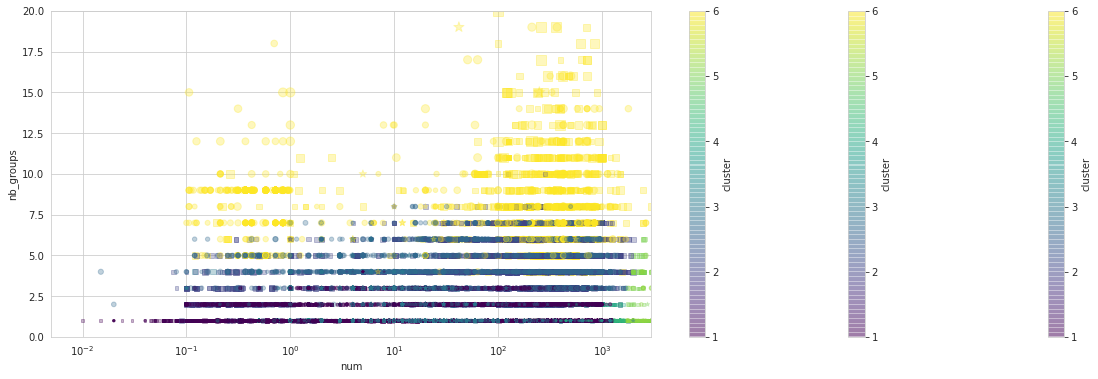

In [0]:
fig = plt.figure(figsize = (21, 6))
grid = plt.GridSpec(1, 1, wspace=0.2, hspace=0.1)
# grid = plt.GridSpec(1, 3, wspace=0.2, hspace=0.1)
np.warnings.filterwarnings('ignore')

mkr_dict = {'mass' : (1,'s'), 'volume' : (2,'o'), 'other' : (0,'*')}

ax1 = plt.subplot(grid[0, 0:1])
for mkr in mkr_dict:
  mask = df_quantity_f['q_unit_type'] == mkr_dict[mkr][0]
  log_num_max = 100*np.log(df_quantity_f[mask]['num'])
  df_quantity_f[mask].plot(ax = ax1, kind = 'scatter',
                           s = df_quantity_f[mask]['nb_char'],
                           y='nb_groups',x='num', c='cluster',
                           marker = mkr_dict[mkr][1], colormap='viridis',
                           xlim = (0,3000), ylim = (0,20), logx = True,
                           alpha=0.3, legend = False,) # figsize = (18,6))

plt.show()

In [0]:
### Function giving description of data in a cluster
def analyses_cluster (df,n):
  df_cl = df[df['cluster']==n]
  print("o---- CLUSTER ", str(n), " ----o")
  print("nb rows", df_cl.shape[0])
  print("min and max num: ", df_cl['num'].min(), df_cl['num'].max())
  print("nb of empty unit: ", df_cl[(df_cl['unit']=='')].shape[0])
  print(df_cl['nb_groups'].value_counts())
 # print("----------- Data in the cluster with empty unit_max : --------")
 # return df_cl[(df_cl['unit_max']=='')]

In [0]:
# Checking the repartition of rows between clusters
for i in range(n_clust):
  print("cluster "+str(i)+" :",df_quantity_f[df_quantity_f['cluster']==i].shape)
# Then giving a summary of main characteristics
for i in range(n_clust):
  analyses_cluster(df_quantity_f,i)

cluster 0 : (59402, 13)
cluster 1 : (195138, 13)
cluster 2 : (17773, 13)
cluster 3 : (5783, 13)
cluster 4 : (86880, 13)
cluster 5 : (1056, 13)
cluster 6 : (1873, 13)
o---- CLUSTER  0  ----o
nb rows 59402
min and max num:  0.02 1250.0
nb of empty unit:  0
1    56304
2     2393
3      703
4        2
Name: nb_groups, dtype: int64
o---- CLUSTER  1  ----o
nb rows 195138
min and max num:  0.01 400.0
nb of empty unit:  0
1    188239
2      6072
3       815
4        12
Name: nb_groups, dtype: int64
o---- CLUSTER  2  ----o
nb rows 17773
min and max num:  0.015 2000.0
nb of empty unit:  0
4     8289
6     4024
5     2093
3     1791
7      947
2      578
8       38
1       11
10       2
Name: nb_groups, dtype: int64
o---- CLUSTER  3  ----o
nb rows 5783
min and max num:  0.1 2000.0
nb of empty unit:  0
1    5342
3     190
2     185
4      48
5      12
6       6
Name: nb_groups, dtype: int64
o---- CLUSTER  4  ----o
nb rows 86880
min and max num:  320.0 1756.0
nb of empty unit:  0
1    84333
2     2

In [0]:
# indexes of rows with empty 'unit'
idx_unit_na = df_quantity[df_quantity['unit'].isna()].index.to_list()
print("Found {} empty 'unit'.\n".format(len(idx_unit_na)))

# indexes of rows with 'num' 0, negative or values exceeding 6000
cond1 = df_quantity['num'].isna()
cond2 = df_quantity['num']>10000
cond3 = df_quantity['num']<=0
my_cond = (cond1|cond2|cond3)
idx_num_outl = df_quantity[my_cond].index.to_list()
print("Total {} outliers found in 'num'.".format(len(idx_num_outl)))
print("--> NaN: {0} - Outliers: {1} - Zero or negative: {2}"\
      .format(df_quantity[cond1].shape[0],
              df_quantity[cond2].shape[0],
              df_quantity[cond3].shape[0]))

Found 9524 empty 'unit'.

Total 10974 outliers found in 'num'.
--> NaN: 9524 - Outliers: 176 - Zero or negative: 1274


In [0]:
# Dropping rows where unit or num is invalid in df_quantity
df_quantity.drop(index=idx_unit_na+idx_num_outl, inplace=True)
# Setting value of 'quantity' in dfcopy also to NaN if unit or num is invalid 
dfcopy.loc[idx_unit_na+idx_num_outl, 'quantity'] = np.nan

In [0]:
# Merging df_quantity with dfcopy
print("dfcopy before: \n", dfcopy.shape,
      "\ndf_quantity: \n", df_quantity.shape)
dfcopy = dfcopy.merge(df_quantity[['num', 'unit','q_unit_type']],
                      how = 'left',  left_index=True, right_index=True)
dfcopy.rename(columns = {'num':'quantity_num',
                         'unit':'quantity_unit',
                          'q_unit_type':'quantity_type'},
                inplace=True)
# ---- NB : join on index works, whereas join on column 'quantity' doesn't.
cols = dfcopy.columns.to_list()
cols = cols[:9]+cols[-3:]+cols[9:-3]
dfcopy = dfcopy[cols]
print("---> dfcopy after: \n", dfcopy.shape)
dfcopy.head(3)

dfcopy before: 
 (1213975, 95) 
df_quantity: 
 (367915, 12)
---> dfcopy after: 
 (1213975, 98)


,code,code_val,url,creator,created_datetime,last_modified_datetime,product_name,generic_name,quantity,quantity_num,quantity_unit,quantity_type,packaging,brands,origins,manufacturing_places,labels,labels_en,emb_codes,first_packaging_code_geo,cities_tags,purchase_places,stores,countries,countries_en,ingredients_text,allergens,traces,traces_en,serving_size,serving_quantity,additives_n,additives_en,ingredients_from_palm_oil_n,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_tags,energy-kj_100g,energy-kcal_100g,energy_100g,...,-lactose_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,selenium_100g,iodine_100g,ph_100g,cocoa_100g,nutriscore,nutrigrade,nutriscore-fr,nova_group
0,0000000000017,True,http://world-en.openfoodfacts.org/product/0000...,kiliweb,2018-06-15T10:38:00Z,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,nan,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,France,NaN,NaN,NaN,NaN,NaN,nan,nan,NaN,nan,NaN,nan,NaN,nan,1569,1569,...,nan,nan,nan,nan,8,1,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,nan,nan
1,0000000000031,True,http://world-en.openfoodfacts.org/product/0000...,isagoofy,2018-10-13T21:06:14Z,2018-10-13T21:06:57Z,Cacao,NaN,130 g,130,g,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,France,NaN,NaN,NaN,NaN,NaN,nan,nan,NaN,nan,NaN,nan,NaN,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,nan,nan
2,000000000003327986,False,http://world-en.openfoodfacts.org/product/0000...,kiliweb,2019-11-19T15:02:16Z,2019-11-19T15:02:17Z,Filetes de pollo empanado,NaN,NaN,nan,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:es,Spain,NaN,NaN,NaN,NaN,NaN,nan,nan,NaN,nan,NaN,nan,NaN,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,nan,nan


In [0]:
# Checking rows with insufficient identification data
# Indexes of rows with invalid codes AND all key_cols NaN
key_cols = ['product_name', 'quantity_num','quantity_unit', 'brands']
m_wcode = dfcopy['code_val']==False
m_wkeys = dfcopy.loc[:,key_cols].isna().all(axis=1)

ind_drop = dfcopy[m_wcode&m_wkeys].index.to_list()

print("nb of rows with invalid code", m_wcode.sum())
print("nb of rows with all key-columns NaN:", m_wkeys.sum())
print("nb of rows with invalid code AND all key-columns NaN (to drop):", (m_wcode&m_wkeys).sum())

nb of rows with invalid code 23153
nb of rows with all key-columns NaN: 36834
nb of rows with invalid code AND all key-columns NaN (to drop): 1845


Data that have no key column filled have very few data anyway.
We drop all the 22183 rows.

In [0]:
# Dropping rows with invalid codes AND all key_cols NaN
print("nb of rows before:", dfcopy.shape[0])
dfcopy.drop(index=ind_drop, inplace=True)
print("nb of rows after:", dfcopy.shape[0])

nb of rows before: 1213975
nb of rows after: 1212130


#### *Condition 2*:

Let's now check for the second condition that is "at least one numerical columns filled" among a selection of numerical data OR nutritional score

In [0]:
def nb_rows_allna (df, selcol):
  mask = dfcopy[selcol].isna().all(axis=1)
  ind_drop = dfcopy[mask].index.to_list()
  return len(ind_drop), ind_drop
  
def print_nb(df, selcol):
  print("------ columns: ", selcol, "\nnb of rows all NaN : ", nb_rows_allna(df, selcol)[0])

In [0]:
list(dfcopy.columns)

['code', 'code_val', 'url', 'creator', 'created_datetime', 'last_modified_datetime', 'product_name', 'generic_name', 'quantity', 'quantity_num', 'quantity_unit', 'quantity_type', 'packaging', 'brands', 'origins', 'manufacturing_places', 'labels', 'labels_en', 'emb_codes', 'first_packaging_code_geo', 'cities_tags', 'purchase_places', 'stores', 'countries', 'countries_en', 'ingredients_text', 'allergens', 'traces', 'traces_en', 'serving_size', 'serving_quantity', 'additives_n', 'additives_en', 'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_tags', 'energy-kj_100g', 'energy-kcal_100g', 'energy_100g', 'energy-from-fat_100g', 'fat_100g', 'saturated-fat_100g', 'pnns_gp_2', 'pnns_gp_1', 'main_category_en', 'main_category', 'categories_en', 'categories', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 'omega-3-fat_100g', '-alpha-linolenic-acid_100g', 'omega-6-fat_100g', 'trans-fat_100g', 

In [0]:
# Display amount of rows to drop depending on selection of columns considered
cruc_num_col = ['energy_100g']
print_nb(dfcopy, cruc_num_col)
cruc_num_col += li_cat_comp
print_nb(dfcopy, cruc_num_col)
cruc_num_col += ['salt_100g']
print_nb(dfcopy, cruc_num_col)
cruc_num_col += li_cat_vit_oligo
print_nb(dfcopy, cruc_num_col)
cruc_num_col += li_cat_nutri
print_nb(dfcopy, cruc_num_col)

------ columns:  ['energy_100g'] 
nb of rows all NaN :  254954
------ columns:  ['energy_100g', 'fat_100g', 'carbohydrates_100g', 'proteins_100g'] 
nb of rows all NaN :  253374
------ columns:  ['energy_100g', 'fat_100g', 'carbohydrates_100g', 'proteins_100g', 'salt_100g'] 
nb of rows all NaN :  242550
------ columns:  ['energy_100g', 'fat_100g', 'carbohydrates_100g', 'proteins_100g', 'salt_100g', 'vitamin-e_100g', 'vitamin-k_100g', 'vitamin-c_100g', 'vitamin-b1_100g', 'vitamin-b2_100g', 'vitamin-pp_100g', 'vitamin-b6_100g', 'vitamin-b9_100g', 'folates_100g', 'vitamin-b12_100g', 'biotin_100g', 'pantothenic-acid_100g', 'bicarbonate_100g', 'potassium_100g', 'chloride_100g', 'calcium_100g', 'phosphorus_100g', 'iron_100g', 'magnesium_100g', 'zinc_100g', 'copper_100g', 'manganese_100g', 'selenium_100g', 'iodine_100g', 'cocoa_100g'] 
nb of rows all NaN :  242281
------ columns:  ['energy_100g', 'fat_100g', 'carbohydrates_100g', 'proteins_100g', 'salt_100g', 'vitamin-e_100g', 'vitamin-k_100g'

We drop the 184 115 rows that do not have either one of the following 36 numerical '**XXX_100g**' columns:

['energy_100g'] + li_cat_comp + ['salt_100g'] + li_cat_vit_oligo

However, we keep the data with no nutritional data in **li_cat_nutri** columns, as we are going to try to reconsruct those data later.

In [0]:
# Dropping rows with no numerical data filled among 'cruc_num_col' columns
cruc_num_col = ['energy_100g'] + li_cat_comp + ['salt_100g'] + li_cat_vit_oligo
print("nb of rows before:", dfcopy.shape[0])
print(nb_rows_allna(dfcopy, cruc_num_col)[0], "rows to drop")
dfcopy.drop(index=nb_rows_allna(dfcopy, cruc_num_col)[1], inplace=True)
print("nb of rows after:", dfcopy.shape[0])

nb of rows before: 1212130
242281 rows to drop
nb of rows after: 969849


In [0]:
speak('Dropped inoperable rows')

### 5. Dealing with duplicates
At first we are going to deal with 'absolute' duplicates (i.e. duplicate on each row). We'll simply keep the first row.


In [0]:
# 1 - Checking for duplicates on all columns
df_dup_all = dfcopy[dfcopy.duplicated(keep=False)]
print("Nb of duplicated rows on all columns:", df_dup_all.shape[0])

Nb of duplicated rows on all columns: 36


In [0]:
# -> Keeping the first duplicated row
print("before", dfcopy.shape[0])
dfcopy = dfcopy[~dfcopy.duplicated(keep='first')]
print("after", dfcopy.shape[0])

before 969849
after 969831


Then, to deal with the duplicates on differents subsets of the columns (['code'] and key_cols), we are going to define a function that combines all the duplicated rows in one. The main row will be the one that has the greater number of unique not null values, and it will be unriched by date from the others rows if available (using pd.DataFrame.combine_first).

In [0]:
# Function combining all dupl. rows,
# '1st' is the one with highest unique notna val.
''' Among each group of duplicates :
 - finds nb of unique notna for each row
 - selects the one with the most unique notna
 - combines the rows (1st is the selected row)
 - replaces all the rows by combined row
 - returns nb of grps of dupl., indexes of rows to drop, list of rows for update
 '''
def comb_dup_rows(df, cols):
  uniq_notna = lambda x:pd.notna(x.unique()).sum()
  df_f = pd.DataFrame({})
  l_ind = []
  cpt = 0
  for k,df_g in df.groupby(by=cols): # loop on all grps of dup.
    df_comb = pd.DataFrame({})
    ser_gr = df_g.apply(uniq_notna, axis=1)
    idx_max = np.argmax(ser_gr)
    ind = list(ser_gr.index)
    ind.remove(idx_max)
    df_comb = df_g.loc[idx_max]
    for i in ind: # loop on all dupl. except that with max unique not na
      df_comb = df_comb.combine_first(df_g.loc[i])
    df_f = df_f.append(df_comb)
    l_ind += ind
    cpt += 1
  df_f.reindex(columns=df.columns) #reorder the columns (bug in pd.concat)
  return cpt, l_ind, df_f 

Let's apply this function to dfcopy, with the subset ['code'] for the duplicates:

In [0]:
# 2 - Checking for duplicates on 'code'
df_dup = dfcopy[dfcopy.duplicated(subset=['code'],keep=False)]
print("Nb of duplicated rows on 'code':", df_dup.shape[0])

Nb of duplicated rows on 'code': 88


In [0]:
# duplicates on 'code' column
# -> Keeping the combined row, deleting the others
print("Shape of dfcopy, before", df_dup.shape[0])
nb_gr, ind_drop, df_dup_f = comb_dup_rows(df_dup, ['code'])
df_dup.drop(ind_drop, inplace=True)
df_dup.update(df_dup_f, overwrite=True)
print("Nb of groups of duplicates :", nb_gr)
print("Nb of duplicates :", df_dup.shape[0])
print("Nb of rows to delete:", len(ind_drop))
print("Shape of dfcopy, after", df_dup.shape[0])

Shape of dfcopy, before 88


ValueError: ignored

In [0]:
# Changing dfcopy
dfcopy.drop(ind_drop, inplace=True)
dfcopy.update(df_dup_f, overwrite=True)

In [0]:
speak('dropping duplicates (on column code)')

29 duplicates has be deleted, and 29 rows updated.

Let's apply this function to dfcopy, with the subset key_cols for the duplicates:

In [0]:
dfcopy.groupby(['code_val']).size()

In [0]:
# 3 - Checking for duplicates on key_cols
key_cols = ['product_name', 'quantity_num', 'quantity_unit', 'brands']
m_dup_keys = dfcopy.duplicated(subset=key_cols,keep=False)
m_c_inval = dfcopy['code_val']==False
df_dup_k_c_val = dfcopy[m_dup_keys & ~m_c_inval]
df_dup_k_c_inval= dfcopy[m_dup_keys & m_c_inval]
print(f"Nb of duplicated rows on key_cols with VALID code: {df_dup_k_c_val.shape[0]}" )
print(f"Nb of duplicated rows on key_cols with INVALID code: {df_dup_k_c_inval.shape[0]}")

If there is duplicates with different code, and at least one of them is valide and one invalid, we want to keep only the rows with valide codes:

In [0]:
# Finding duplicates with at least 1 row with valid code AND 1 invalid code
df_mixed_dup = dfcopy[m_dup_keys].groupby(by=key_cols)\
                .filter(lambda x:sum((x['code_val']==True).values)>1\
                        and sum((x['code_val']==False).values)>1)

In [0]:
# df_mixed_dup.sort_values(by=key_cols)
gb = df_mixed_dup.groupby(by=key_cols)
print(f"Nb of rows with mixed val/inval codes: {sum(gb.size())}")
print(f"Nb of groups of duplicates: {len(gb)}")

In [0]:
# shows example of duplicates on key_cols with mixed 'code_val'
gb.get_group(list(gb.groups.keys())[0])

In [0]:
# Dropping the rows with invalid codes in each group
print("Shape of dfcopy, before", dfcopy.shape[0])
for i in range(len(gb)):
  d = gb.get_group(list(gb.groups.keys())[i])
  ind = d[d['code_val']==False].index
  dfcopy.drop(index=ind, inplace=True)
print("Shape of dfcopy, after", dfcopy.shape[0])

In [0]:
# Refreshing the list
m_dup_keys = dfcopy.duplicated(subset=key_cols,keep=False)
m_c_inval = dfcopy['code_val']==False
df_dup_k_c_val = dfcopy[m_dup_keys & ~m_c_inval]
df_dup_k_c_inval= dfcopy[m_dup_keys & m_c_inval]
print(f"Nb of duplicated rows on key_cols with VALID code: {df_dup_k_c_val.shape[0]}" )
print(f"Nb of duplicated rows on key_cols with INVALID code: {df_dup_k_c_inval.shape[0]}")

In [0]:
# Duplicates on key_cols column with invalid codes
# -> Keeping the combined row, deleting the others
print("Shape of df_dup_k_c_inval, before", df_dup_k_c_inval.shape[0])
nb_gr, ind_drop, df_dup_f = comb_dup_rows(df_dup_k_c_inval, key_cols)
df_dup_k_c_inval.drop(ind_drop, inplace=True)
df_dup_k_c_inval.update(df_dup_f, overwrite=True)
print("Nb of groups of duplicates :", nb_gr)
print("Nb of duplicates :", df_dup_k_c_inval.shape[0])
print("Nb of rows to delete:", len(ind_drop))
print("Shape of df_dup_k_c_inval, after", df_dup_k_c_inval.shape[0])

In [0]:
# Changing dfcopy
dfcopy.drop(ind_drop, inplace=True)
dfcopy.update(df_dup_k_c_inval, overwrite=True)

In [0]:
# list(df.columns[df.columns.str.contains('nutri')]) 'nutriscore_score', 'nutrition-score-fr_100g'

## 2. Cleaning numerical data

In [0]:
dfcopy.select_dtypes(include=[float]).head()

### 2.1 Dealing with outliers

In [0]:
cols_100g = list(dfcopy.columns[dfcopy.columns.str.contains('_100g')])
df_100g = dfcopy.loc[:,cols_100g].astype(float).copy()
df_cat_nutri = pd.concat([dfcopy.loc[:,'nutriscore'].astype(float), dfcopy.loc[:,['nutrigrade','pnns_gp1', 'main_categ_en']]]).copy()
df_cat_nutri.columns=['nutriscore','nutrigrade','pnns_gp1', 'main_categ_en']
df_cat_nutri

In [0]:
dfcopy.loc[:,'nutriscore'].isna().sum(), df_cat_nutri.loc[:,'nutriscore'].isna().sum()

(618398, 1569519)

#### 2.1.1 columns about nutriscores

In [0]:
speak("attention savastoppé")

In [0]:
# Checking if ther are rows where 'nutriscore' is different from 'nutriscore-fr'
cond = dfcopy['nutriscore']==dfcopy['nutriscore-fr']
dfcopy.dropna(subset=['nutriscore', 'nutriscore-fr'])[~cond].shape[0]

0

Column 'nutriscore' is not different from 'nutriscore-fr'.
 We merge the columns and delete 'nutriscore-fr'




In [0]:
dfcopy['nutriscore'] = dfcopy["nutriscore-fr"].combine_first(dfcopy["nutriscore"])
dfcopy.drop(columns=["nutriscore-fr"], inplace=True)

The nutrigrade is assigned to a product after consideration of :
- its nutriscore
- whether it's solid food or beverage 

In [0]:
dfcopy.groupby('quantity_type').size()

quantity_type
0      1850
1    236707
2     43174
dtype: int64

In [0]:
# dfcopy.boxplot(by=['nutrigrade', 'quantity_type'])

In [0]:
gb = dfcopy.groupby(by=['nutrigrade', 'quantity_type'])

"Outil_Calcul_Nutri-Score_SpF-030120" :
https://www.santepubliquefrance.fr/determinants-de-sante/nutrition-et-activite-physique/articles/nutri-score (tableur excel)

1823 products are not identified as liquid/beverage or solid/food.
Let's see if we can guess from the categories columns. 

#### 2.2.2 Columns about energy

en

In [0]:
list(df_100g.columns)

In [0]:
df_100g.boxplot(['energy_100g', 'energy-from-fat_100g',
                 'energy-kj_100g', 'energy-kcal_100g'],
                vert=False, figsize=(21,3))

In [0]:
# Distinguish situation 3 columns filled ?
gb = df_100g.notna().groupby(by=['energy_100g', 'energy-kcal_100g', 'energy-kj_100g'])
gb.size()

In [0]:
# group1: all nan, can't do anything for the moment
df_gp1 = df_100g.loc[gb.groups.get((False, False, False))]
df_gp1.shape

In [0]:
# group2: group to send to the model -> is it kj or kcal ?
df_gp2 = df_100g.loc[gb.groups.get((True, False, False))]
df_gp2.shape

In [0]:
# group3: group where e is j
df_gp3 = df_100g.loc[gb.groups.get((True, False, True))]
print(df_gp3.shape)
m_id3 = df_gp3.apply(lambda x: x['energy-kj_100g']==x['energy_100g'], axis=1)
df_gp3[~m_id3].shape # cas où ils sont différents (2) : prévoir remplacement (fonction)

In [0]:
# group4: group where e is c 
df_gp4 = df_100g.loc[gb.groups.get((True, True, False))]
print(df_gp4.shape)
m_id4 = df_gp4.apply(lambda x: x['energy-kcal_100g']==x['energy_100g'], axis=1)
df_gp4[~m_id4].shape # cas où ils sont différents (0) : prévoir remplacement (fonction)

In [0]:
# group5: group where e, c and j are both filled : are they the same ? which is the correct one ? to be submitted to the model
df_gp5 = df_100g.loc[gb.groups.get((True, True, True))]
print(df_gp5.shape)
f_e_eq_c = lambda x: x['energy-kcal_100g']==x['energy_100g']
f_e_eq_j = lambda x: x['energy-kj_100g']==x['energy_100g']
m_id_c5 = df_gp5.apply(f_e_eq_c, axis=1)
m_id_j5 = df_gp5.apply(f_e_eq_j, axis=1)
df_gp5_A = df_gp5[(m_id_c5&m_id_j5)]
df_gp5_B = df_gp5[(~m_id_c5)&(~m_id_j5)]
df_gp5_C = df_gp5[(~(m_id_c5&m_id_j5))&(~((~m_id_c5)&(~m_id_j5)))]
df_gp5_C_c = df_gp5_C[m_id_c5]
df_gp5_C_j = df_gp5_C[m_id_j5]
print(df_gp5_A.shape) # cas où j, c et e sont égaux (env 2 000)
print(df_gp5_B.shape) # cas où e, c et j sont tous différents (0)
print(df_gp5_C.shape) # cas où j, e et c ne sont pas tous égaux mais pas tous différents (au moins un couple égaux) (env 20 000)
print(df_gp5_C_c.shape)
print(df_gp5_C_j.shape)

In [0]:
'''données False True True inexistantes 
préparer un modèle pour détecter la catégorie de calorie (True False False)
éliminer données False False False
d'abord modifier les données de type True True True en : True True False ou True, False true
puis garder les données de type
True, False, True ou
True, True, False
------------------
les données auront 4 colonnes et 1 target
target à créer : kcal 0 ou 1
mettre en place un modèle random forest

In [0]:
# Gathering rows and columns to forme a dataset
sel_en_cols = ['energy_100g','fat_100g', 'carbohydrates_100g', 'proteins_100g',
            'fiber_100g', 'alcohol_100g', 'pnns_gp1', 'main_categ_en', 'nutriscore', 'nutrigrade']
train_set = pd.concat([df_gp3[m_id3], df_gp3[m_id3]])[sel_en_cols]

In [0]:
train_set.drop(columns=['energy_calc_kcal_100g', 'energy_calc_kj_100g'], inplace=True)

In [0]:
train_set[['fat_100g', 'proteins_100g','carbohydrates_100g']].astype(float)

In [0]:
# Creating two calculated versions of energy (kcal) and (kj)
def calc_en_from_c_f_p(df):
  res_c = df['fat_100g'].fillna(0)*9\
          +(df['carbohydrates_100g'].fillna(0)+df['proteins_100g'.fillna(0)])*4\
          +df['fiber_100g'].fillna(0)*1.9+df['alcohol_100g'].fillna(0)*7
  res_j = res_c*418.4
  return res_c, res_j

ser_c,ser_j = calc_en_from_c_f_p(train_set)
# train_set.insert(1, 'energy_calc_kcal_100g', ser_c)
# train_set.insert(2, 'energy_calc_kj_100g', ser_j)
# train_set.sample(5)

calc_en_from_c_f_p(train_set)[0]


In [0]:
df_100g.boxplot(column=['energy_100g'], by='cal_j',vert=False, figsize=(21,3))

In [0]:
# @interact
# def adjust_a(a=(0,1,0.1)):
#   return [a*x for x in range(0,35000)]
  
# ax0 = df_100g.plot(kind='scatter', x='energy-kj_100g', y='energy-kcal_100g', c='red', s=5)
# df_100g.plot(kind='line', x='energy-kj_100g', y=adjust_a(), c='grey', ax=ax0)

In [0]:
ax1 = df_100g.plot(kind='scatter', x='energy_100g', y='energy-kcal_100g', c='red', s=50)
for col,c,s in [('energy-kj_100g','b',25), ('energy_100g','grey',1)]:
  df_100g.plot.scatter(x='energy_100g', y=col, s=s, c=c,ax=ax1,)

In [0]:
speak("Abracadabraaaaa é voilà ")